In [32]:
import time
import math
import nbimporter
import numpy as np
import pandas as pd
import backtest as bt
import preprocessing as pp
import helper_methods as hm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier


from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import datetime

In [3]:
df = pp.read_file('AAPL')
df = df[:250]
df.head()

,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,DIV_AMT,SPLIT_COEFF
DATE,,,,,,,,
2018-10-19,218.06,221.26,217.4300,219.31,219.31,33078726,0.0,1.0
2018-10-18,217.86,219.74,213.0000,216.02,216.02,32581315,0.0,1.0
2018-10-17,222.30,222.64,219.3400,221.19,221.19,22885397,0.0,1.0
2018-10-16,218.93,222.99,216.7627,222.15,222.15,29183963,0.0,1.0
2018-10-15,221.16,221.83,217.2700,217.36,217.36,30791007,0.0,1.0


In [74]:
df_shift, y = make_forecasting_frame(df['ADJ_CLOSE'], kind='price', max_timeshift=20, rolling_direction=1)
print(df_shift.shape)
df_shift.head()

(4790, 4)


,time,value,id,kind
4541,2017-10-24,154.7619,2017-10-25,price
4293,2017-10-24,154.7619,2017-10-26,price
4542,2017-10-25,154.0822,2017-10-26,price
4046,2017-10-24,154.7619,2017-10-27,price
4294,2017-10-25,154.0822,2017-10-27,price


In [75]:
X = extract_features(df_shift, column_id='id', column_sort='time', column_value='value', 
                     impute_function=impute, show_warnings=False)




Feature Extraction: 100%|██████████| 10/10 [00:10<00:00,  1.12it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend

In [76]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(249, 794)
(249, 347)


In [77]:

# Add last value as feature
X["feature_last_value"] = y.shift(1)

In [78]:
# Drop first line
X = X.iloc[1:-2, ]
y = y.iloc[1:-1 ]
y.head()

DATE
2018-10-17    221.19
2018-10-16    222.15
2018-10-15    217.36
2018-10-12    222.11
2018-10-11    214.45
Name: value, dtype: float64

In [79]:
X[-5:]

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""",...,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,,,,,,,,,,,
2018-10-11,996916.4203,52.91,-0.091783,0.121956,0.262063,226.41,1.0,5.66,224.972,0.462046,...,1.0,1.0,1.0,1.0,-38904.474947,31194.393543,190805.756270,18.429395,1.0,222.11
2018-10-12,991643.7347,52.25,-0.009710,0.059397,0.281143,224.95,1.0,7.12,224.501,0.573888,...,1.0,1.0,1.0,1.0,-57660.241534,18675.777972,125623.240652,21.409229,1.0,217.36
2018-10-15,990872.2412,53.95,0.013329,0.092942,0.286286,225.74,1.0,6.33,222.150,0.701811,...,1.0,1.0,1.0,1.0,2343.428597,31734.167262,103887.871537,21.340764,1.0,222.15
2018-10-16,990645.9164,58.34,0.065557,0.204752,0.344052,227.26,1.0,4.81,223.290,0.643772,...,1.0,1.0,1.0,1.0,15257.016963,-23581.293559,26778.574718,21.595720,1.0,221.19
2018-10-17,992367.8413,63.00,0.023914,0.116615,0.261167,229.28,1.0,2.79,226.022,0.068382,...,1.0,1.0,1.0,1.0,5954.271881,-3731.177620,845.698654,20.652335,1.0,216.02


In [59]:
# X.isnull().sum().sum()
# null_columns=X.columns[X.isnull().any()]
# X[null_columns].isnull().sum()
# print(X[X.isnull()][null_columns])

In [60]:
# X - X.dropna()

In [80]:
# This function returns the daily returns of the stock based on a specified parameter within the data (Using Taylor series approximation)
def data_daily_returns(y):
    daily_returns = list()
    date = list()
    for i in range(len(y) - 1):
        abs_t1 = math.log10(y.loc[y.index[i]])
        abs_t0 = math.log10(y.loc[y.index[i + 1]])
        daily_returns.append(abs_t1 - abs_t0)
        date.append(y.index[i])
    return pd.DataFrame(daily_returns, index=date)


y = data_daily_returns(y)
y.head()


,0
2018-10-17,-0.001881
2018-10-16,0.009467
2018-10-15,-0.009388
2018-10-12,0.015242
2018-10-11,-0.003851


In [81]:
y = hm.output_to_binary_indicators(y)
y.head()

,0
2018-10-17,-1.0
2018-10-16,1.0
2018-10-15,-1.0
2018-10-12,1.0
2018-10-11,-1.0


In [82]:
y = y.iloc[::-1]
y.head()

,0
2017-10-26,1.0
2017-10-27,1.0
2017-10-30,1.0
2017-10-31,1.0
2017-11-01,-1.0


In [83]:
print(y[-5:])
print(X[-5:])

              0
2018-10-11 -1.0
2018-10-12  1.0
2018-10-15 -1.0
2018-10-16  1.0
2018-10-17 -1.0
variable    value__abs_energy  value__absolute_sum_of_changes  \
id                                                              
2018-10-11        996916.4203                           52.91   
2018-10-12        991643.7347                           52.25   
2018-10-15        990872.2412                           53.95   
2018-10-16        990645.9164                           58.34   
2018-10-17        992367.8413                           63.00   

variable    value__agg_autocorrelation__f_agg_"mean"__maxlag_40  \
id                                                                
2018-10-11                                          -0.091783     
2018-10-12                                          -0.009710     
2018-10-15                                           0.013329     
2018-10-16                                           0.065557     
2018-10-17                                    

In [84]:
print(X.shape)
print(y.shape)
split_index =  int(0.75 * len(X.index))
X_train, X_test = X.iloc[0:split_index, :], X.iloc[split_index:, :]
Y_train, Y_test = y.iloc[0:split_index], y.iloc[split_index]
y.head()

(246, 348)
(246, 1)


,0
2017-10-26,1.0
2017-10-27,1.0
2017-10-30,1.0
2017-10-31,1.0
2017-11-01,-1.0


In [85]:
for k in range(1, 5):
    print('k: ', k)
    sklearn_KNN_forecast(X_train, X_test, Y_train, Y_test, k)
    print('\n\n')

k:  1
SKLEARN INBUILT


ValueError: Found input variables with inconsistent numbers of samples: [1, 62]

### K-NN Classifier Implementation 

In [3]:
class K_Nearest_Neighbours_Classifier:
    
    def __init__(self, k_neighbours):
        self.k_neighbours = k_neighbours
    
    # This function was meant to train the data - but no explicit training in K-NN
    def fit(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        return
    
    
    # This function uses the training data and the feature values to the data sample to be predicted on. 
    # Using the specified number of nearest neighbours, it returns the predicted classification of the specificed data sample
    def predict_one(self, x_test_point):
        distances = []
        for i in range(len(self.X_train)):
            # sum of square of distance of each feature - minkowski Distance with p = 2
            distance = ((self.X_train[i, :] - x_test_point)**2).sum()
            # appending the list of the distance for the point and its index to the list
            distances.append([distance, i])

        # Sorting using the distance from the sample point
        distances = sorted(distances)

        targets = []
        # Finding the classification of the elements using the first 'k' elemets in the distances list i.e 'k' nearest neighbours
        for i in range(self.k_neighbours):
            # list of the indices of the 'k' nearest neighbours
            index_of_training_data = distances[i][1]

            # adding the nearest neighbours to the targets list
            targets.append(self.Y_train[index_of_training_data])

        # returns the most common entry among the targets
        return Counter(targets).most_common(1)[0][0]
    
    
    # This function uses the training data, the data samples to be predicted upon and the value of k
    # It return the predicted classification values of the data samples given to it for prediction
    def predict(self, x_test_data):
        predictions = []

        # making prediction for the testing data samples
        for x_test in x_test_data:
            predictions.append(self.predict_one(x_test))
        return predictions
    
    
    # This function uses the training data, the data samples to be predicted upon and the value of k
    # It returns the predicted classification of the data samples given to it for prediction 
    # while updating the training data after each prediction
    def predict_and_update(self, x_test_data, y_test_data):
        predictions = []

        # making prediction for the testing data samples
        for i in range(len(x_test_data)):
            x_test = x_test_data[i]
            y_test = y_test_data[i]

            y_pred = self.predict_one(x_test)
            predictions.append(y_pred)

            # updating the training dataset to include the point just predicted upon
            self.X_train = np.append(self.X_train, [x_test], axis=0)
            self.Y_train = np.append(self.Y_train, [y_test], axis=0)

        return predictions

### Using CV to find Optimal parameters

Sorting list: https://stackoverflow.com/questions/17555218/python-how-to-sort-a-list-of-lists-by-the-fourth-element-in-each-list  

In [4]:
def print_parameters_accuracy(accuracies):
    print('#Features \t #Neighbours \t Accuracy')
    for i in range(len(accuracies)):
        print(accuracies[i][0], '\t\t', accuracies[i][1], '\t\t', accuracies[i][2])
    print()

In [5]:
def find_optimal_values(max_features, max_neighbours, num_splits = 10, symbol_name = 'AAPL', use_implementation = True):
    accuracies = list()
    for num_features in range(1, max_features + 1, 1):
        print('Features:', num_features)
        
        X_train, X_test, Y_train, Y_test = hm.prepare_data(num_features, symbol_name, is_binary_ouput=True)
        X_train, X_test, Y_train, Y_test = X_train.values, X_test.values, Y_train.values, Y_test.values
        
        for k_neighbours in range(1, max_neighbours + 1, 2):
            print('Neighbours ------------------------>', k_neighbours)
#             knn_tscv = K_Nearest_Neighbours_Classifier(k_neighbours=k_neighbours)
            knn_tscv = KNeighborsClassifier(n_neighbors=k_neighbours)
#             knn_tscv = KNeighborsClassifier(n_neighbors=int(len(X_train) ** 0.5))
            if use_implementation:
                neighbour_accuracy = hm.timeSeriesCV(X_train, Y_train, num_splits, knn_tscv, is_classification=True)
            else:
                neighbour_accuracy = hm.rolling_cross_validation(X_train, Y_train, num_splits, knn_tscv, is_classification=True)
            accuracies.append([num_features, k_neighbours, neighbour_accuracy])
    
    print_parameters_accuracy(accuracies)
    
    # Sorting the accuracies
    accuracies.sort(reverse=True, key=lambda x: x[2])
    print_parameters_accuracy(accuracies)
    
    return accuracies[0][0], accuracies[0][1]

In [6]:
def get_data_ready(symbol_name, max_features=5, max_neighbours=11):
    start_time = time.time()
    num_features, k_neighbours = find_optimal_values(max_features=max_features, max_neighbours=max_neighbours, num_splits=10, symbol_name = symbol_name)
    end_time = time.time()
    print('Time taken for Cross Validation:', end_time - start_time)
    
    X_train, X_test, Y_train, Y_test = hm.prepare_data(num_features, symbol_name)
    X_train, X_test, Y_train, Y_test = X_train.values, X_test.values, Y_train.values, Y_test.values
    return X_train, X_test, Y_train, Y_test, k_neighbours    

### 1. SKLearn KNN Classifier

In [17]:
def sklearn_KNN_forecast(X_train, X_test, Y_train, Y_test, k_neighbours):
    print('SKLEARN INBUILT')
    clf = KNeighborsClassifier(n_neighbors=k_neighbours)
    clf.fit(X_train, Y_train)
    print('Accuracy Score --', clf.score(X_test, Y_test))

### 2. Predicting using Implementation

In [8]:
def implemented_KNN_forecast(X_train, X_test, Y_train, Y_test, k_neighbours):
    knn = K_Nearest_Neighbours_Classifier(k_neighbours)
    knn.fit(X_train, Y_train)
    
    print('IMPLEMENTATION') 
    Y_pred = knn.predict(X_test)
    hm.accuracy_metrics(Y_test, Y_pred)

    print('IMPLEMENTATION WITH TRAINING UPDATES') 
    Y_pred = knn.predict_and_update(X_test, Y_test)
    hm.accuracy_metrics(Y_test, Y_pred)

### 3. Sliding Window/Sliding Simulation Approach

In [9]:
def sliding_window(X_train, X_test, Y_train, Y_test, k_neighbours, window_size):
    knn = K_Nearest_Neighbours_Classifier(k_neighbours)
    
    print(X_train[:window_size, :])
    print(Y_train[:window_size])
    print(len(Y_test))
    
    X_train = X_train[:window_size, :]
    Y_train = Y_train[:window_size]
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test[-1:, 0])
    
    
    for i in range(len(Y_test)):
        knn.fit
    
    x_train = X_train[:window_size, :]
    knn.fit(X_train, Y_train)

### Running KNN

In [10]:
def forecast(X_train, X_test, Y_train, Y_test, k_neighbours):
    print('Number of Neighbours --', k_neighbours)
    sklearn_KNN_forecast(X_train, X_test, Y_train, Y_test, k_neighbours)
    implemented_KNN_forecast(X_train, X_test, Y_train, Y_test, k_neighbours)
#     sliding_window(X_train, X_test, Y_train, Y_test, k_neighbours, 5)

# X_train, X_test, Y_train, Y_test = hm.prepare_data(2)
# X_train, X_test, Y_train, Y_test = X_train.values, X_test.values, Y_train.values, Y_test.values
# forecast(X_train, X_test, Y_train, Y_test, 9)

In [17]:
def run_KNN(symbol_name):
    max_features = 13
    max_neighbours = 21
    X_train, X_test, Y_train, Y_test, k_neighbours = get_data_ready(symbol_name, max_features, max_neighbours)
    print(X_train)
    forecast(X_train, X_test, Y_train, Y_test, k_neighbours)

Features: 1
Neighbours ------------------------> 1
Implemented Rolling Cross Validation
Accuracy: 0.5040871934604906 

Neighbours ------------------------> 3
Implemented Rolling Cross Validation
Accuracy: 0.48894943990311834 

Neighbours ------------------------> 5
Implemented Rolling Cross Validation
Accuracy: 0.5034816833181955 

Neighbours ------------------------> 7
Implemented Rolling Cross Validation
Accuracy: 0.5028761731759007 

Neighbours ------------------------> 9
Implemented Rolling Cross Validation
Accuracy: 0.50650923402967 

Neighbours ------------------------> 11
Implemented Rolling Cross Validation
Accuracy: 0.5083257644565546 

Neighbours ------------------------> 13
Implemented Rolling Cross Validation
Accuracy: 0.49984862246442624 

Neighbours ------------------------> 15
Implemented Rolling Cross Validation
Accuracy: 0.5074174992431123 

Features: 2
Neighbours ------------------------> 1
Implemented Rolling Cross Validation
Accuracy: 0.49258250075688764 

Neighbour

Accuracy: 0.5109289617486339 

Neighbours ------------------------> 9
Implemented Rolling Cross Validation
Accuracy: 0.5154826958105647 

Neighbours ------------------------> 11
Implemented Rolling Cross Validation
Accuracy: 0.5145719489981785 

Neighbours ------------------------> 13
Implemented Rolling Cross Validation
Accuracy: 0.5121432908318153 

Neighbours ------------------------> 15
Implemented Rolling Cross Validation
Accuracy: 0.5200364298724955 

Features: 11
Neighbours ------------------------> 1
Implemented Rolling Cross Validation
Accuracy: 0.49726775956284147 

Neighbours ------------------------> 3
Implemented Rolling Cross Validation
Accuracy: 0.4893746205221615 

Neighbours ------------------------> 5
Implemented Rolling Cross Validation
Accuracy: 0.509411050394657 

Neighbours ------------------------> 7
Implemented Rolling Cross Validation
Accuracy: 0.5063752276867031 

Neighbours ------------------------> 9
Implemented Rolling Cross Validation
Accuracy: 0.509714632

[[-0.00545387 -0.0011997   0.01421733 ... -0.00130402 -0.0017766
  -0.01389892]
 [-0.0011997   0.01421733 -0.02415932 ... -0.0017766  -0.01389892
  -0.02098916]
 [ 0.01421733 -0.02415932 -0.00017376 ... -0.01389892 -0.02098916
  -0.00920093]
 ...
 [ 0.00156169  0.00055946 -0.00385552 ...  0.00283669  0.00502638
   0.0002724 ]
 [ 0.00055946 -0.00385552 -0.00674357 ...  0.00502638  0.0002724
  -0.00267245]
 [-0.00385552 -0.00674357  0.00518592 ...  0.0002724  -0.00267245
  -0.00493849]]
Number of Neighbours -- 11
SKLEARN INBUILT
Accuracy Score -- 0.4918300653594771
IMPLEMENTATION
------------------------------------------------
Accuracy:  0.4918300653594771
Matthews Correlation Coefficient:  -0.015576305463697822
Cohen Kappa Score:  -0.015407268304133526
Confustion Matrix
[[342 266]
 [356 260]]
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.56      0.52       608
         1.0       0.49      0.42      0.46       616

   micro a

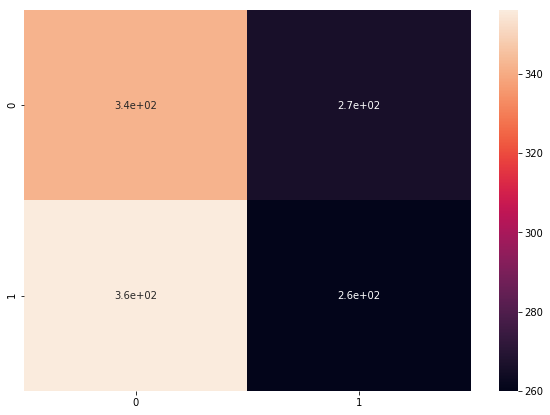

------------------------------------------------
IMPLEMENTATION WITH TRAINING UPDATES
------------------------------------------------
Accuracy:  0.5008169934640523
Matthews Correlation Coefficient:  0.002820207474804811
Cohen Kappa Score:  0.002773540424351739
Confustion Matrix
[[358 250]
 [361 255]]
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.59      0.54       608
         1.0       0.50      0.41      0.45       616

   micro avg       0.50      0.50      0.50      1224
   macro avg       0.50      0.50      0.50      1224
weighted avg       0.50      0.50      0.50      1224



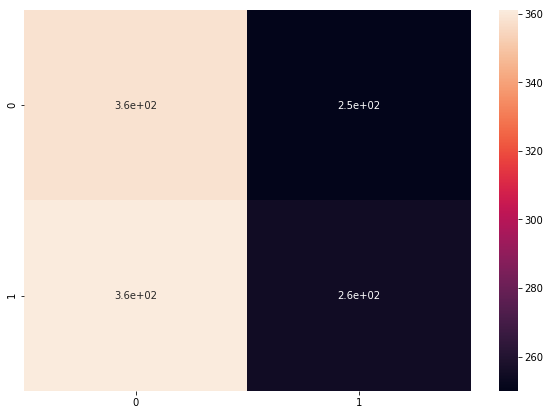

------------------------------------------------


In [16]:
run_KNN(symbol_name = 'MSFT')

In [24]:
from sklearn.metrics import accuracy_score

symbol_name = 'AAPL'

X_train, X_test, Y_train, Y_test = hm.prepare_data(1, symbol_name)
X_train, X_test, Y_train, Y_test = X_train.values, X_test.values, Y_train.values, Y_test.values
print(len(Y_test))
clf1 = KNeighborsClassifier(n_neighbors=13)
clf1.fit(X_train, Y_train)
y_pred = clf1.predict(X_test)
print(accuracy_score(y_pred, Y_test))
cum_y_pred = y_pred

for i in range(5, -1, -1):
    print(y_pred[-i], '\t', Y_test[-1])

X_train, X_test, Y_train, Y_test = hm.prepare_data(1, symbol_name)
X_train, X_test, Y_train, Y_test = X_train.values, X_test.values, Y_train.values, Y_test.values
print(len(Y_test))
clf2 = KNeighborsClassifier(n_neighbors=11)
clf2.fit(X_train, Y_train)
y_pred = clf2.predict(X_test)
print(accuracy_score(y_pred, Y_test))
cum_y_pred += y_pred

for i in range(5, -1, -1):
    print(y_pred[-i], '\t', Y_test[-1])

X_train, X_test, Y_train, Y_test = hm.prepare_data(1, symbol_name)
X_train, X_test, Y_train, Y_test = X_train.values, X_test.values, Y_train.values, Y_test.values
print(len(Y_test))
clf3 = KNeighborsClassifier(n_neighbors=9)
clf3.fit(X_train, Y_train)
y_pred = clf3.predict(X_test)
print(accuracy_score(y_pred, Y_test))
cum_y_pred += y_pred

for i in range(5, -1, -1):
    print(y_pred[-i], '\t', Y_test[-1])


cum_y_pred = np.abs(cum_y_pred) / cum_y_pred
print(accuracy_score(cum_y_pred, Y_test))

for i in range(5, -1, -1):
    print(cum_y_pred[-i], '\t', Y_test[-1])

Getting File from:  ../data/alphaVantage/AAPL-full-daily_adjusted.csv
1309
0.5217723453017571
1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
-1.0 	 1.0
Getting File from:  ../data/alphaVantage/AAPL-full-daily_adjusted.csv
1309
0.5064935064935064
1.0 	 1.0
1.0 	 1.0
-1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
-1.0 	 1.0
Getting File from:  ../data/alphaVantage/AAPL-full-daily_adjusted.csv
1309
0.5049656226126814
1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
-1.0 	 1.0
0.5095492742551566
1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
1.0 	 1.0
-1.0 	 1.0
